In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import warnings
import string
import re

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [2]:
francetax = pd.read_parquet('data/france_revenue_tax_syndicates.parquet')

In [3]:

# Function to standardize municipality names
def standardize_name(name):
    return ''.join(char for char in name if char not in string.punctuation).strip().upper()

# Apply the function to the 'Libellé commune' column
francetax['Libellé commune'] = francetax['Libellé commune'].apply(standardize_name)

# Convert columns to appropriate data types
francetax[['TFNB', 'TFB', 'TH', 'TP']] = francetax[['TFNB', 'TFB', 'TH', 'TP']] .apply(pd.to_numeric, errors='coerce')

# Create a complete range of years for each municipality
years = np.arange(1982, 2023)
all_municipalities = francetax['Libellé commune'].unique()

# Create a complete DataFrame with all municipalities and all years
complete_data = pd.MultiIndex.from_product([all_municipalities, years], names=['Libellé commune', 'ANNEE']).to_frame(index=False)

# Merge with the existing data
data_complete = pd.merge(complete_data, francetax, on=['Libellé commune', 'ANNEE'], how='left')

In [4]:
# Function to fill missing data for each municipality
def fill_missing_data(df):
    for col in ['TFNB', 'TFB', 'TH', 'TP']:
        df[col] = df[col].fillna(method='ffill')  # Fill using data from the previous year
        if df[col].isna().sum() > 0:
            df[col] = df[col].fillna(df[col].rolling(window=5, min_periods=1).mean())  # Fill remaining using the mean of the previous years
    return df

# Apply the function to each municipality
data_complete = data_complete.groupby('Libellé commune').apply(fill_missing_data).reset_index(drop=True)


In [5]:
# Conversion rate from francs to euros
conversion_rate = 6.55957

# Identify rows where year is before 2002
mask = data_complete['ANNEE'] < 2002

# Apply conversion to the tax columns
data_complete.loc[mask, 'TFNB'] = data_complete.loc[mask, 'TFNB'] / conversion_rate
data_complete.loc[mask, 'TFB'] = data_complete.loc[mask, 'TFB'] / conversion_rate
data_complete.loc[mask, 'TH'] = data_complete.loc[mask, 'TH'] / conversion_rate
data_complete.loc[mask, 'TP'] = data_complete.loc[mask, 'TP'] / conversion_rate


In [6]:
def impute_taxes(group):
    for col in ['TFNB', 'TFB', 'TH', 'TP']:
        values = group[col]
        
        for i in range(len(values)):
            if pd.isna(values.iloc[i]):
                # Get the previous 5 years
                previous_values = values.iloc[max(0, i-5):i]
                
                if not previous_values.isna().all():
                    # If there are previous values, use the mean or median
                    if len(previous_values.dropna()) > 0:
                        values.iloc[i] = previous_values.mean()
                    else:
                        values.iloc[i] = previous_values.median()
                else:
                    # If all upcoming years are NaN, impute 0
                    values.iloc[i] = 0
    
    return group


# App#ly the imputation function to each municipality group
data = data_complete.groupby('Libellé commune').apply(impute_taxes)
data.head()


,Libellé commune,ANNEE,COMMUNE,TFNB,TFB,TH,SYNDICATE_TFNB,SYNDICATE_TFB,SYNDICATE_TH,TP,POPULATION
0,ABERGEMENT CLEMENCIAT,1982,NaN,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN
1,ABERGEMENT CLEMENCIAT,1983,NaN,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN
2,ABERGEMENT CLEMENCIAT,1984,NaN,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN
3,ABERGEMENT CLEMENCIAT,1985,NaN,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN
4,ABERGEMENT CLEMENCIAT,1986,NaN,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN


In [7]:
def standardize_name(name):
    return re.sub(r'\W+', '', name).strip().upper()  # Remove non-alphanumeric characters and convert to uppercase

# Create a mapping from standardized names to original names
data['Standardized Name'] = data['Libellé commune'].apply(standardize_name)
name_mapping = data.drop_duplicates('Standardized Name')[['Standardized Name', 'Libellé commune']].set_index('Standardized Name')['Libellé commune'].to_dict()

# Use the standardized names in the main data
data['Libellé commune'] = data['Standardized Name']
data = data.drop(columns=['Standardized Name'])

#SAVE CLEANED DATA
data.to_parquet('data/francetax_processed_TP.parquet')

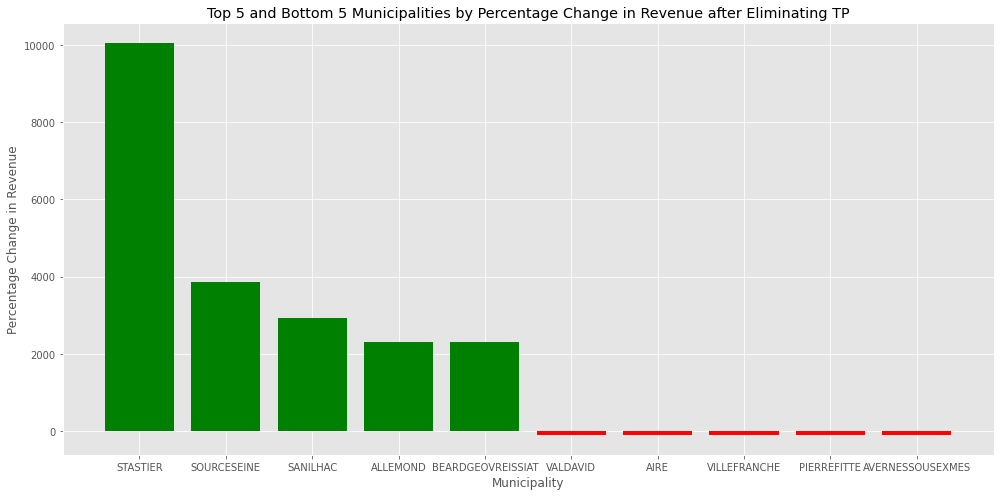

In [32]:
municipal_counts = data['Libellé commune'].value_counts()
valid_municipalities = municipal_counts[municipal_counts >= 10].index
filtered_data = data[data['Libellé commune'].isin(valid_municipalities)]

# Split the data for years before and after 2010
data_before_2010 = filtered_data[filtered_data['ANNEE'] < 2010]
data_after_2010 = filtered_data[filtered_data['ANNEE'] >= 2010]

# Group by municipalities and calculate total tax revenue for years before 2010
revenue_before_2010 = data_before_2010.groupby('Libellé commune')[['TFNB', 'TFB', 'TH', 'TP']].sum()
revenue_before_2010['Total_Revenue_Before_2010'] = revenue_before_2010.sum(axis=1)

# Filter out municipalities with zero revenue before 2010
revenue_before_2010 = revenue_before_2010[revenue_before_2010['Total_Revenue_Before_2010'] > 0]

# Group by municipalities and calculate total tax revenue for years after 2010
revenue_after_2010 = data_after_2010.groupby('Libellé commune')[['TFNB', 'TFB', 'TH']].sum()
revenue_after_2010['Total_Revenue_After_2010'] = revenue_after_2010.sum(axis=1)

# Merge the two datasets to compare the total revenue before and after 2010
revenue_comparison = revenue_before_2010[['Total_Revenue_Before_2010']].merge(
    revenue_after_2010[['Total_Revenue_After_2010']],
    left_index=True,
    right_index=True,
    how='inner'
)

# Calculate the change in revenue
revenue_comparison['Revenue_Change'] = revenue_comparison['Total_Revenue_After_2010'] - revenue_comparison['Total_Revenue_Before_2010']
revenue_comparison['Revenue_Change_Percentage'] = (revenue_comparison['Revenue_Change'] / revenue_comparison['Total_Revenue_Before_2010']) * 100

# Handle infinite values
revenue_comparison.replace([np.inf, -np.inf], np.nan, inplace=True)
revenue_comparison.dropna(subset=['Revenue_Change_Percentage'], inplace=True)

# Get the top 5 and bottom 5 municipalities based on percentage change
top_5_municipalities = revenue_comparison.nlargest(5, 'Revenue_Change_Percentage')
bottom_5_municipalities = revenue_comparison.nsmallest(5, 'Revenue_Change_Percentage')

# Combine top and bottom municipalities for plotting
top_bottom_municipalities = pd.concat([top_5_municipalities, bottom_5_municipalities])

# Plotting the results
plt.figure(figsize=(14, 7))
plt.bar(top_bottom_municipalities.index, top_bottom_municipalities['Revenue_Change_Percentage'], 
        color=['green' if x >= 0 else 'red' for x in top_bottom_municipalities['Revenue_Change_Percentage']])
plt.xlabel('Municipality')
plt.ylabel('Percentage Change in Revenue')
plt.title('Top 5 and Bottom 5 Municipalities by Percentage Change in Revenue after Eliminating TP')

plt.tight_layout()
plt.show()